In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import torch
import torch.nn as nn
import torchvision.transforms.functional as T
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

from pretrain import init, train
from configs import FCConfig, CAEConfig, MAEConfig
from src.data.collators import fc_collator
from src.utils.utils import set_random_seed

from src.model.FullyConnectedAE import FCAutoencoder
from src.model.ConvolutionalAE import CNNAutoencoder
from src.model.mae.MAE import MAE

from src.data.dataset import get_train_dataset, get_val_dataset
from train import init_classifier, train_classifier

plt.rcParams['font.size'] = 20

In [2]:
RANDOM_STATE = 322
set_random_seed(RANDOM_STATE)

### Setting up some useful functions

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def draw_pretrain_plot(train_losses, val_losses):
    x = np.arange(len(train_losses))

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_losses, c="C0", label="train")
    plt.plot(x, val_losses, c="C1", label="val")
    plt.title("Pretrain model losses")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.semilogy()
    plt.legend()


@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None, mae=False):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor().to(device)
    restored_img_batch = torch.Tensor().to(device)
    masked_batch = torch.Tensor().to(device)
    for idx in ids:
        img, _ = dataset[idx]
        if collator is not None:
            img, _ = collator([(img, _)])
        else:
            img = img.unsqueeze(0)
        img = img.to(device, non_blocking=True)
        restored_img = model(img)
        if mae:
            restored_img, mask = restored_img
            masked_batch = torch.cat([masked_batch, img * (1 - mask)], dim=0)
        if f is not None:
            img = f(img).unsqueeze(0)
            restored_img = f(restored_img).unsqueeze(0)
        img_batch = torch.cat([img_batch, img], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img], dim=0)

    img_batch = make_grid(img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    restored_img_batch = make_grid(restored_img_batch.cpu(), nrow=num_images, padding=1, normalize=True,
                                   value_range=(-1, 1))
    if mae:
        masked_batch = make_grid(masked_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
        grid = torch.cat([img_batch, masked_batch, restored_img_batch], dim=1)
    else:
        grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid


def show_grid(grid, img_size=(5, 5)):
    fig, axs = plt.subplots(figsize=(5 * img_size[0], 5 * img_size[1]),
                            squeeze=False)
    grid = grid.detach()
    grid = T.to_pil_image(grid)
    axs[0, 0].imshow(grid)
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def pretrain(model, optimizer, criterion, scheduler, train_dataloader,
             val_dataloader, val_dataset, num_epoches, checkpoint_path, f=None, collator=None,
             mae=False):
    train_losses = []
    val_losses = []
    for epoch in range(num_epoches):
        train_loss, val_loss = train(model, optimizer, criterion, scheduler,
                                     train_dataloader, val_dataloader, checkpoint_path,
                                     device=device, num_epoches=1)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        clear_output()
        draw_pretrain_plot(train_losses, val_losses)
        grid = construct_grid(model, val_dataset, f=f, collator=collator, mae=mae)
        show_grid(grid)
        plt.show()


def experiment(config, model_constructor, img_reshaper=None, data_collator=None,
               mae=False):
    model, optimizer, criterion, scheduler = init(config, model_constructor)
    model.to(device)

    train_dataset = get_train_dataset("../data", False)
    val_dataset = get_val_dataset("../data", False)
    train_dataloader = DataLoader(train_dataset, config.train_config.train_batch_size, shuffle=True,
                                  num_workers=6, collate_fn=data_collator, pin_memory=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, config.train_config.eval_batch_size, shuffle=False,
                                num_workers=6, collate_fn=data_collator, pin_memory=True)

    pretrain(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
             val_dataset, config.train_config.num_epoches,
             config.train_config.checkpoint_path, img_reshaper, data_collator, mae=mae)

    return model

In [4]:
neighbours_set = np.linspace(5, 100, 10).astype(np.int32)


def find_hyperparam(X_train, y_train):
    folds = 10
    kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
    acc = []
    for neighbours in neighbours_set:
        acc.append(0)
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            model = KNeighborsClassifier(n_neighbors=neighbours, n_jobs=8).fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)
            y_pred = torch.tensor(y_pred, device=y_test_cv.device)
            acc[-1] += torch.mean((y_test_cv == y_pred).float())
        acc[-1] /= folds

    return neighbours_set[np.array(acc).argmax()]


def knn_based_accuracy(X_train, y_train, n_neighbours):
    folds = 5
    kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
    acc = []
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        model = KNeighborsClassifier(n_neighbors=n_neighbours, n_jobs=8).fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        y_pred = torch.tensor(y_pred, device=y_test_cv.device)
        acc.append(torch.mean((y_test_cv == y_pred).float()).item())

    return np.mean(acc)

### Pretraining

#### Fully connected autoencoder

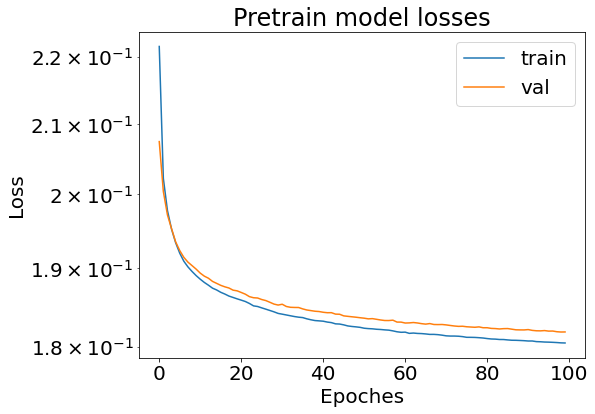

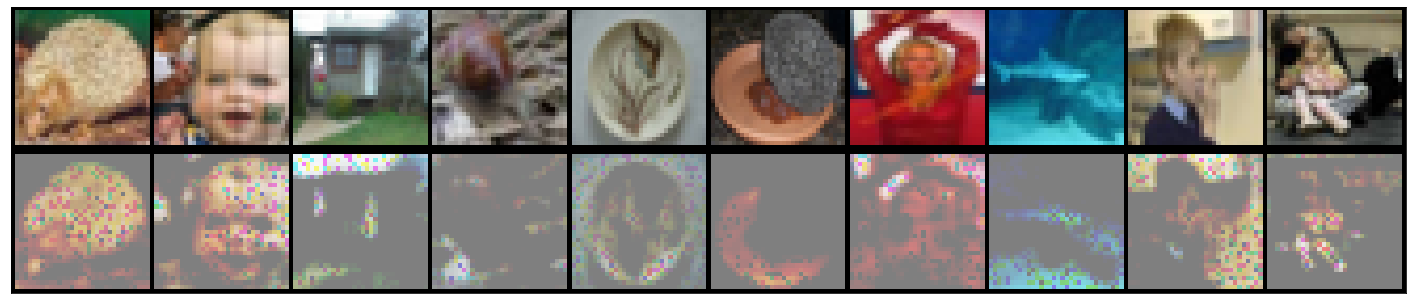

FCAutoencoder(
  (encoder): FCEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=1536, out_features=768, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=768, out_features=384, bias=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (decoder): FCDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=384, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1536, out_features=3072, bias=True)
      (5): ReLU(inplace=True)
      (6): Tanh()
    )
  )
)

In [16]:
config = FCConfig
constructor = FCAutoencoder
fc_image_reshaper = lambda img: img.view(3, 32, 32)
experiment(config, constructor, fc_image_reshaper, fc_collator)


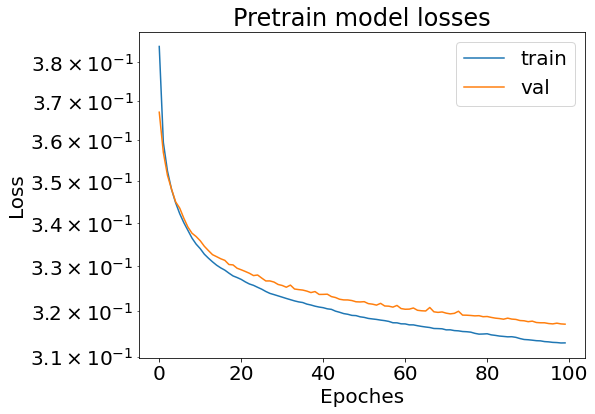

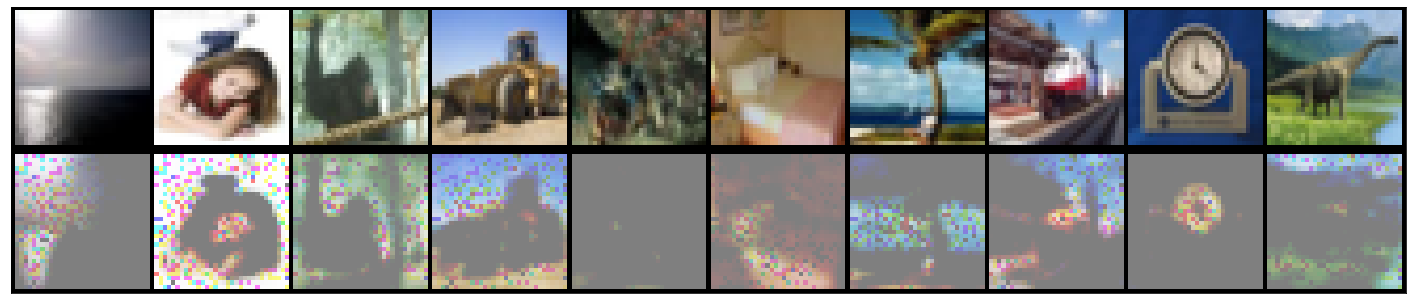

In [18]:
l1_config = copy.deepcopy(FCConfig)
l1_config.train_config.loss = nn.L1Loss
experiment(l1_config, constructor, fc_image_reshaper, fc_collator)


#### Convolutional-based autoencoder

In [5]:
N_variants = 5
config_params = {
    "encoder_n_layers": [4, 4, 4, 5, 3],
    "encoder_scale_factor": [2, 3, 2, 2, 2],
    "decoder_n_layers": [4, 4, 4, 5, 3],
    "decoder_scale_factor": [2, 3, 2, 2, 2],
    "start_num_filters": [6, 6, 8, 8, 16],
}
constructor = CNNAutoencoder

metrics = []
params_count = []
inner_dim = []
for i in range(N_variants):
    experiment_cfg = copy.deepcopy(CAEConfig)
    for param in config_params.keys():
        setattr(experiment_cfg.model_config, param, config_params[param][i])

    model = experiment(experiment_cfg, constructor)

    clear_output()
    val_dataset = get_val_dataset("../data", False)
    val_dataloader = DataLoader(val_dataset, FCConfig.train_config.eval_batch_size, shuffle=True,
                                num_workers=6, pin_memory=True)
    X = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    with torch.no_grad():
        for batch, targets in val_dataloader:
            batch = batch.to(device, non_blocking=True)
            X = torch.cat([X, model.encode(batch)], dim=0)
            y = torch.cat([y, targets], dim=0)
    n_neighbours = find_hyperparam(X, y)
    accuracy = knn_based_accuracy(X, y, n_neighbours)
    metrics.append(accuracy)
    params_count.append(sum([p.numel() for p in model.parameters() if p.requires_grad]))
    inner_dim.append(np.prod(model.encode(val_dataset[0][0].unsqueeze(0)).shape))

torch.save(metrics, "metrics.pt")
torch.save(params_count, "params.pt")
torch.save(inner_dim, "inner_dim.pt")

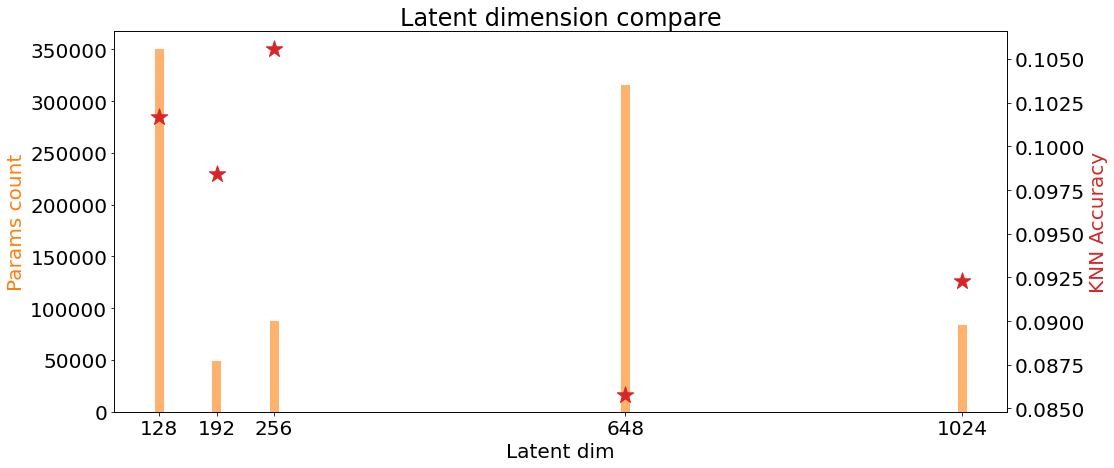

In [34]:
order = np.argsort(inner_dim)
inner_dim = np.asarray(inner_dim)[order]
params_count = np.asarray(params_count)[order]
metrics = np.asarray(metrics)[order]

fig, ax = plt.subplots(figsize=(16, 7))
ax.set(title="Latent dimension compare", xticks=inner_dim,
       xlabel="Latent dim")
ax.set_ylabel("Params count", color="C1")
ax.bar(inner_dim, params_count, width=10, color="C1", alpha=0.6)
ax2 = ax.twinx()
ax2.scatter(inner_dim, metrics, color="C3", marker="*", s=300)
ax2.set_ylabel("KNN Accuracy", color="C3")
plt.show()

It is clear from the bar, that the best quality with least number of parameters we
gain from autoencoders with dimension of latent space of 192 and 256. So, the
following experiments will be spend with this architectures.

192-latent dimension autoencoder pretraining:

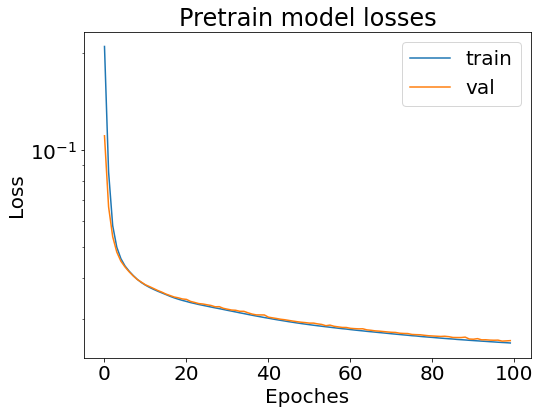

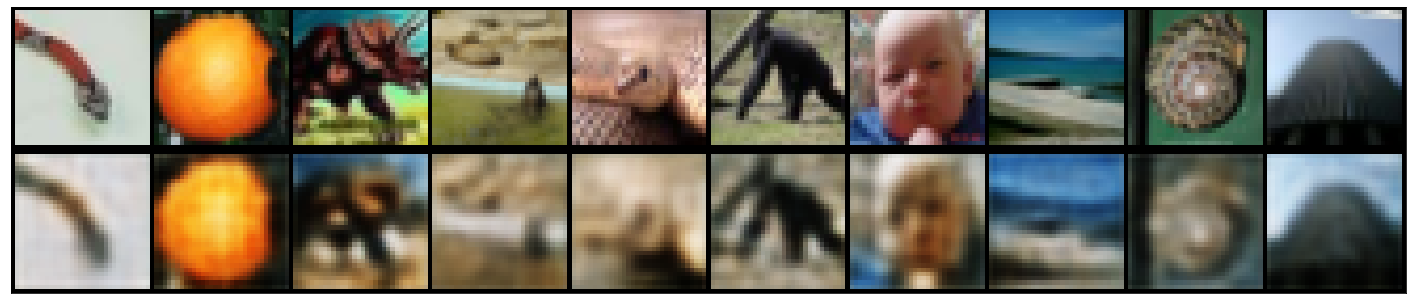

CNNAutoencoder(
  (encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): LayerNorm()
      (5): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): LayerNorm()
      (8): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.2, inplace=True)
      (10): LayerNorm()
      (11): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): CNNDecoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): LayerNorm()
      (3): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     

In [10]:
config = CAEConfig
constructor = CNNAutoencoder
experiment(config, constructor)

256-latent dimension autoencoder pretraining:

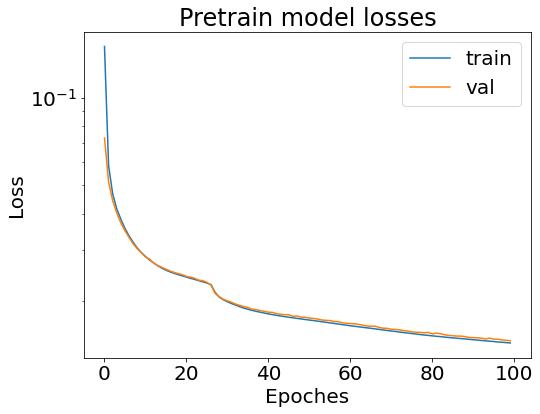

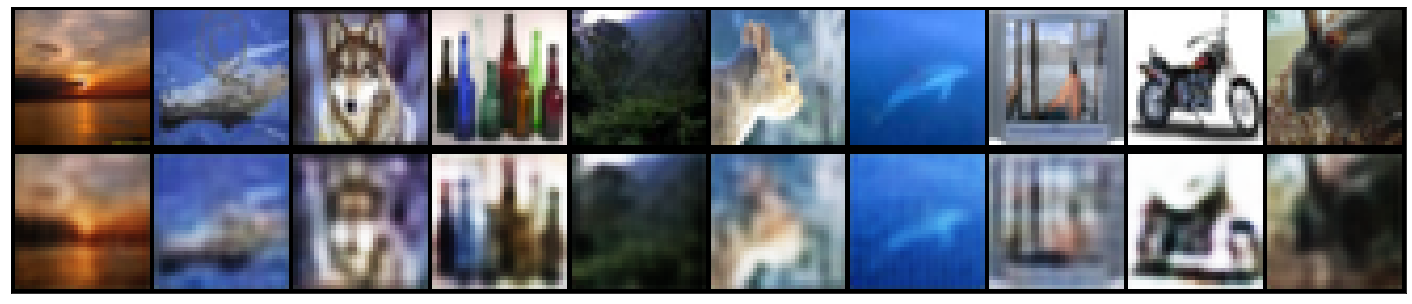

In [11]:
config = CAEConfig
config.model_config.start_num_filters = 8
constructor = CNNAutoencoder
m = experiment(config, constructor)

#### Masked autoencoders

You may find MAE experiment in other notebook.

### Trainig pretrained models

Implementing some more useful functions.

In [9]:
def train_plots(val_losses, val_accs):
    x = np.arange(len(val_losses))
    fig, ax = plt.subplots(1, 2, figsize=(17, 7))
    ax[0].set(title="Validation NLL loss", xlabel="Epoches", ylabel="NLL loss")
    ax[1].set(title="Classifier accuracy", xlabel="Epoches", ylabel="Accuracy")

    ax[0].plot(x, val_losses, c="C1")
    ax[1].plot(x, val_accs, c="C1")
    ax[0].semilogy()


def classifier_train(model, optimizer, criterion, scheduler, train_dataloader,
                     val_dataloader, num_epoches, checkpoint_path):
    val_losses = []
    val_accs = []
    for epoch in range(num_epoches):
        val_loss, val_acc = train_classifier(model, optimizer, criterion, scheduler,
                                             train_dataloader, val_dataloader, checkpoint_path,
                                             device=device, num_epoches=1)
        val_losses.append(val_loss[-1].item())
        val_accs.append(val_acc[-1].item())

        clear_output()
        train_plots(val_losses, val_accs)
        plt.show()

    return val_losses, val_accs


def classifier_experiment(config, model_constructor, pretrained_path=None, mode="fine_tune", freeze=False,
                          num_epoches=10, data_collator=None):
    model, _, _, scheduler = init(config, model_constructor)
    if pretrained_path is not None:
        model.load_state_dict(torch.load(pretrained_path)["model"])
    model = init_classifier(model.encoder, config, mode, freeze).to(device)

    train_dataset = get_train_dataset("../data", False)
    val_dataset = get_val_dataset("../data", False)
    train_dataloader = DataLoader(train_dataset, config.train_config.train_batch_size, shuffle=True,
                                  num_workers=6, collate_fn=data_collator, pin_memory=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, config.train_config.eval_batch_size, shuffle=False,
                                num_workers=6, collate_fn=data_collator, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5 if not freeze else 3e-4)
    criterion = nn.NLLLoss()
    scheduler = scheduler if not freeze else None

    return classifier_train(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
                            num_epoches, config.train_config.checkpoint_path)


def multiaproach_experiment(config, constructor, chechpoint_path, num_epoches=10, data_collator=None):
    results = []
    results.append(
        classifier_experiment(config, constructor, num_epoches=num_epoches, data_collator=data_collator)
    )  #no pretrain results
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="fine_tune",
                              freeze=False, num_epoches=num_epoches, data_collator=data_collator)
    )
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="fine_tune",
                              freeze=True, num_epoches=num_epoches, data_collator=data_collator)
    )
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="probing",
                              freeze=False, num_epoches=num_epoches, data_collator=data_collator)
    )
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="probing",
                              freeze=True, num_epoches=num_epoches, data_collator=data_collator)
    )

    clear_output()
    x = np.arange(num_epoches)
    f, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].set(title="Loss compare", xlabel="Epoches", ylabel="NLL loss")
    ax[1].set(title="Accuracy compare", xlabel="Epoches", ylabel="Accuracy")
    labels = [
        "No pretrain", "Model tune with classifier", "Train only classifier",
        "Model tune with probing", "Train only probing"
    ]
    for i in range(5):
        for j in range(2):
            ax[j].plot(x, results[i][j], c=f"C{i}", label=labels[i])
    ax[0].legend()
    ax[0].semilogy()
    ax[1].legend()
    plt.show()

    print("No pretrain:", np.max(results[0][1]))
    print("Ft:", np.max(results[1][1]))
    print("Ft + freeze:", np.max(results[2][1]))
    print("Probing:", np.max(results[3][1]))
    print("Probing + freeze:", np.max(results[4][1]))

#### Train classifier over fully-connected encoder.

First experiment spend with encoder, pretrained with $L1$ norm.

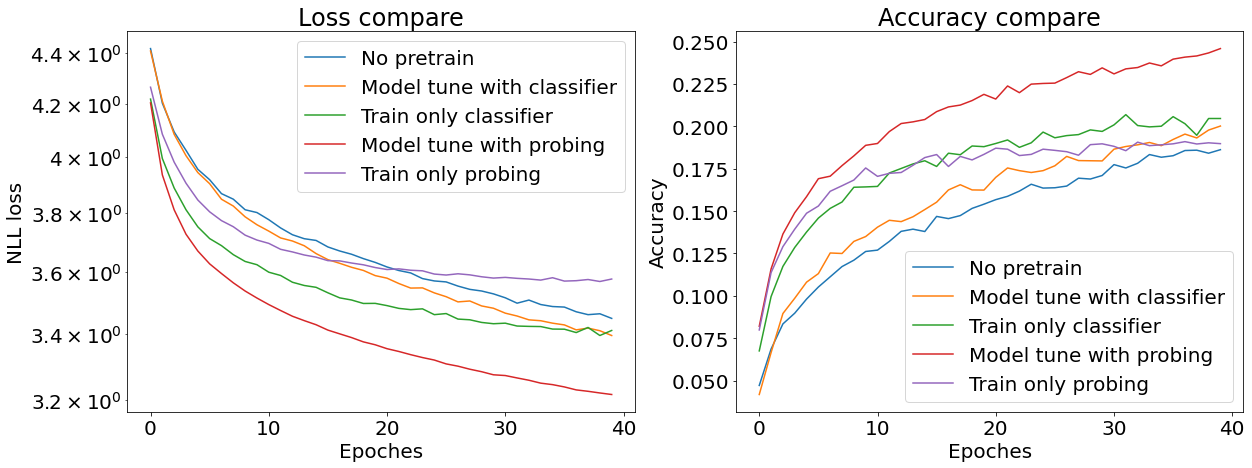

No pretrain: 0.1862144023180008
Ft: 0.2001582384109497
Ft + freeze: 0.20688292384147644
Probing: 0.24584652483463287
Probing + freeze: 0.19096124172210693


In [18]:
config = FCConfig
constructor = FCAutoencoder
num_epoches = 40
path = "../checkpoints/fc/l1_final.pth"
collator = fc_collator

multiaproach_experiment(config, constructor, path, num_epoches, collator)

And for encoder, pretrained with $L2$ norm.

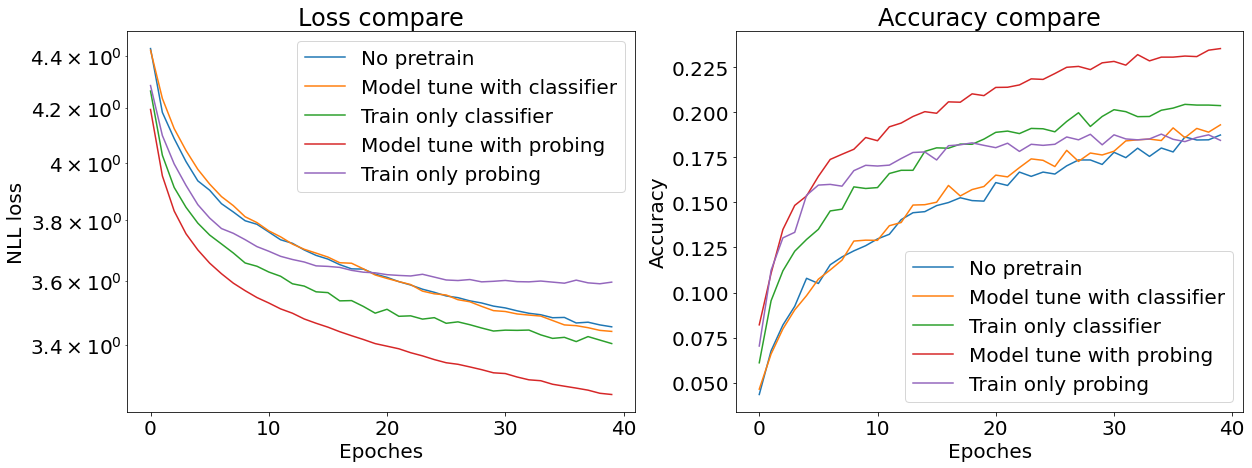

No pretrain: 0.18740111589431763
Ft: 0.1930379867553711
Ft + freeze: 0.2044106125831604
Probing: 0.2353639304637909
Probing + freeze: 0.18789558112621307


In [7]:
config = FCConfig
constructor = FCAutoencoder
num_epoches = 40
path = "../checkpoints/fc/l2_final.pth"
collator = fc_collator

multiaproach_experiment(config, constructor, path, num_epoches, collator)

#### Training classifier over convolutional encoder

Encoder with 192 latent dimension.

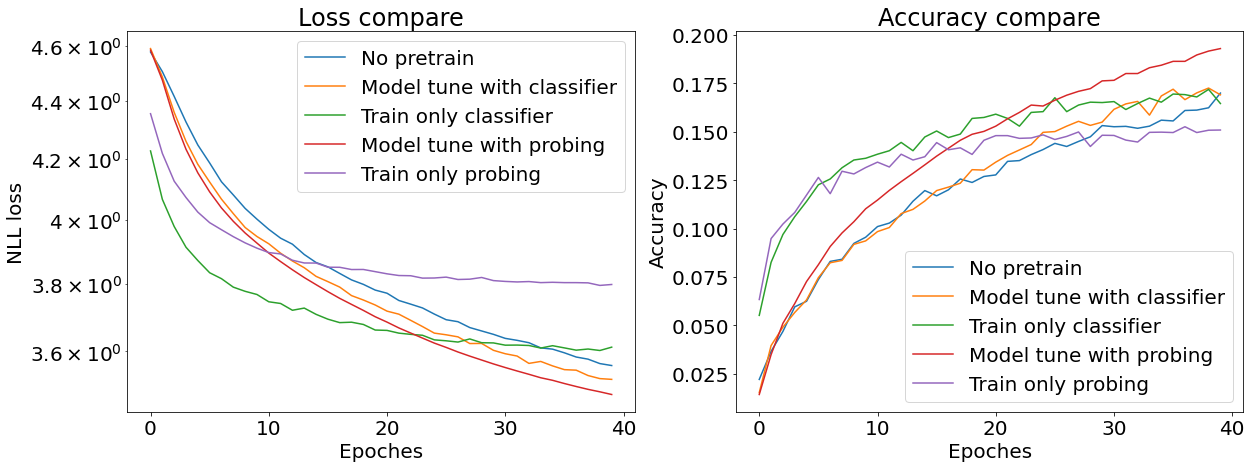

In [10]:
config = CAEConfig
constructor = CNNAutoencoder
num_epoches = 40
path = "../checkpoints/cae/192_final.pth"

multiaproach_experiment(config, constructor, path, num_epoches)

Encoder with 256 latent dimension.

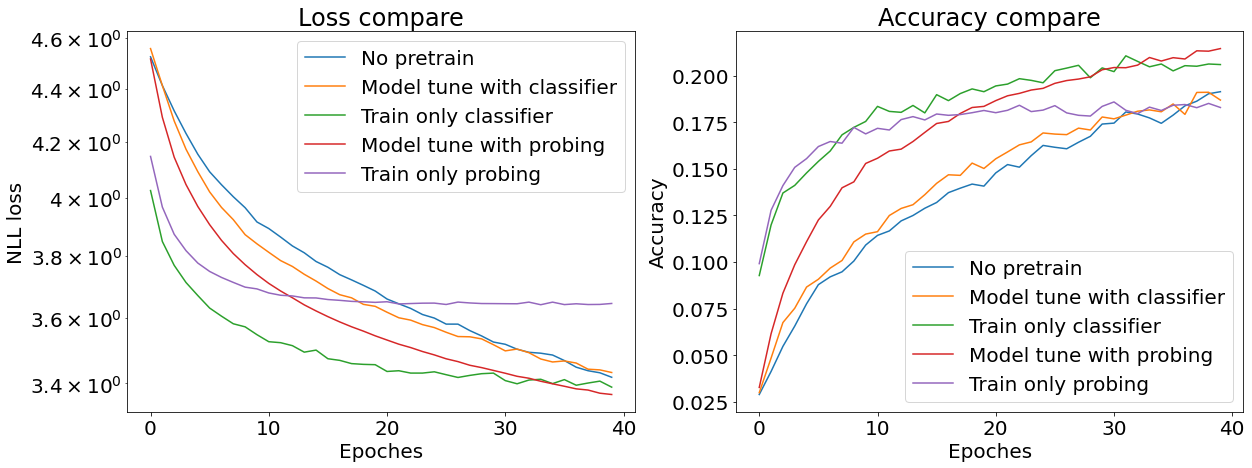

No pretrain: 0.19149360060691833
Ft: 0.191194087266922
Ft + freeze: 0.21076276898384094
Probing: 0.2146565467119217
Probing + freeze: 0.18600238859653473


In [17]:
config = CAEConfig
config.model_config.start_num_filters = 8
config.classifier_config.input_dim = 256
constructor = CNNAutoencoder
num_epoches = 40
path = "../checkpoints/cae/256_final.pth"

multiaproach_experiment(config, constructor, path, num_epoches)
